In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.optim as optim
from torch.nn import BCELoss
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter, Module, LeakyReLU
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

file = '../data/Original/Wimbledon_featured_matches.csv'
df = pd.read_csv(file)
df = df.drop(columns=['elapsed_time'])
 
# TODO: 可以加入speed_mph，可能可以加入上个球的胜负数据？(先验证lstm是否在工作)
type_var = ['match_id', 'player1', 'player2']
num_var = ['set_no', 'game_no',
            'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games',
            'server', 'p1_net_pt', 'p2_net_pt', 'p1_break_pt', 'p2_break_pt',
            'p1_distance_run','p2_distance_run', 'rally_count']

for var in type_var:
    le = preprocessing.LabelEncoder()
    le.fit(df[var])
    df.loc[:, var] = le.transform(df[var])

df.loc[df['point_victor'] == 2, 'point_victor'] = 0

scaler = MinMaxScaler()
df[num_var+type_var] = scaler.fit_transform(df[num_var+type_var])

x = df[num_var+type_var]
y = df["point_victor"]
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

record = pd.DataFrame(data=np.zeros([x.shape[0], 2]), columns=["CLG Predictions", "CGA Predictions"])



In [ ]:
class CLG(nn.Module):
    def __init__(self):
        super(CLG, self).__init__()
        
        # TODO: 可以调整
        self.scale = 8
        self.conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.fft_layer = GlobalFourierTransformEncoder()
        self.lstm = nn.LSTM(input_size=16, hidden_size=8, num_layers=2, batch_first=True)
        self.fc = nn.Linear(8, 1)
        
        # Xavier初始化应用于卷积层和全连接层
        nn.init.xavier_uniform_(self.conv.weight)
        nn.init.xavier_uniform_(self.fc.weight)

        # LSTM层的Xavier初始化（对权重矩阵进行初始化）
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name: # 输入到隐藏层的权重
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name: # 隐藏层到隐藏层的权重
                nn.init.xavier_uniform_(param)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.leaky_relu(self.conv(x))
        x = self.fft_layer(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = torch.sigmoid(self.fc(x))
        # mean_x = torch.mean(x, dim=0, keepdim=True) 
        # x = (x - mean_x) * self.scale + mean_x
        return x

class GlobalFourierTransformEncoder(nn.Module):
    def __init__(self):
        super(GlobalFourierTransformEncoder, self).__init__()
    
    def forward(self, x):
        x_fft = torch.fft.rfft(x, dim=2)
        x_fft_abs = torch.sqrt(torch.real(x_fft)**2 + torch.imag(x_fft)**2)
        return x_fft_abs

In [ ]:
class CGA(nn.Module):
    def __init__(self):
        super(CGA, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        self.gru = nn.GRU(input_size=16, hidden_size=8, num_layers=1, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(8 * 2, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
            nn.Softmax(dim=1)
        )
        self.batch_norm = nn.BatchNorm1d(8 * 2)
        self.output_layer = nn.Linear(8 * 2, 1)

        nn.init.xavier_normal_(self.output_layer.weight)
        self.output_layer.bias.data.fill_(0.1)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x, _ = self.gru(x)
        
        # 应用注意力机制到所有时间步
        attention_weights = self.attention(x).squeeze(-1)
        x_attention = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        
        # 条件性应用Batch Normalization
        if x_attention.size(0) > 1:  # 如果批量大小大于1
            x_attention = self.batch_norm(x_attention)
        
        output = self.output_layer(x_attention)
        output = output.squeeze(dim=1)
        probability = torch.sigmoid(output)
        return probability, attention_weights

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedBCELoss, self).__init__()
        self.weight = weight
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        weighted_bce_loss = bce_loss * self.weight
        loss = torch.mean(weighted_bce_loss)
        return loss

In [ ]:

def train_CLG(train_x, train_y, test_x, indices):
    lossList = []
    # for match_id, group_data in grouped_data:
        # 创建子集数据
    subset_X = torch.tensor(train_x.values.astype(np.float32))
    subset_y = torch.tensor(train_y.values.astype(np.float32))
    test_subset_X = torch.tensor(test_x.values.astype(np.float32))
    
    subset_dataset = TensorDataset(subset_X, subset_y)
    subset_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

    weight = torch.tensor([2.0])

    # 创建子集模型
    subset_model = CLG()
    subset_criterion =  WeightedBCELoss(weight)
    # subset_criterion =  nn.MSELoss()
    subset_optimizer = optim.Adam(subset_model.parameters(), lr=0.005)

    # 训练子集模型
    num_epochs = 5
    for epoch in range(num_epochs):
        print("epoch", epoch)
        for inputs, labels in subset_dataloader:
            outputs = subset_model(inputs)
            labels = labels.unsqueeze(1)
            loss = subset_criterion(outputs, labels)
            
            lossList.append(loss.item())
            
            subset_optimizer.zero_grad()
            loss.backward()
            subset_optimizer.step()

    # 获取子集模型的输出概率
    with torch.no_grad():
        # TODO: 为什么有NaN？梯度爆炸？
        subset_probabilities = subset_model(test_subset_X).squeeze().numpy()
        # print(subset_probabilities)

    # 将子集的输出概率添加到表格中的相应位置
    record["CLG Predictions"][indices] = subset_probabilities
    
    return lossList

In [101]:
def train_CGA(train_x, train_y, test_x, indices):
    lossList = []
    # for match_id, group_data in grouped_data:
    #     # 创建子集数据
    
    subset_X = torch.tensor(train_x.values.astype(np.float32))
    subset_y = torch.tensor(train_y.values.astype(np.float32))
    test_subset_X = torch.tensor(test_x.values.astype(np.float32))
    
    subset_dataset = TensorDataset(subset_X, subset_y)
    subset_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=False)
    
    weight = torch.tensor([2.0])
    
    subset_model = CGA()
    subset_criterion = WeightedBCELoss(weight)
    subset_optimizer = optim.Adam(subset_model.parameters(), lr=0.01)
    
    # 训练子集模型
    num_epochs = 5
    for epoch in range(num_epochs):
        for inputs, labels in subset_dataloader:
            outputs, _ = subset_model(inputs)
            loss = subset_criterion(outputs, labels)
            
            lossList.append(loss.item())
            
            subset_optimizer.zero_grad()
            loss.backward()
            subset_optimizer.step()
    
    # 获取子集模型的输出概率
    with torch.no_grad():
        outputs, _ = subset_model(test_subset_X)
        subset_probabilities = outputs.squeeze().numpy()
    
    # 将子集的输出概率添加到表格中的相应位置
    record["CGA Predictions"][indices] = subset_probabilities
    
    return lossList

working on new fold
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
[1.5556652545928955, 1.5526964664459229, 1.375948190689087, 1.368678331375122, 1.2483705282211304, 1.5774085521697998, 1.3343110084533691, 1.502915859222412, 1.276399850845337, 1.4173040390014648, 1.4039766788482666, 1.3492645025253296, 1.3671457767486572, 1.6083558797836304, 1.3568761348724365, 1.4201555252075195, 1.4735515117645264, 1.3754818439483643, 1.2822829484939575, 1.391191840171814, 1.4266607761383057, 1.4000221490859985, 1.3191969394683838, 1.4496651887893677, 1.3978663682937622, 1.3851664066314697, 1.3169718980789185, 1.282363772392273, 1.3606741428375244, 1.3693572282791138, 1.3928852081298828, 1.3095225095748901, 1.2241792678833008, 1.3702592849731445, 1.3370598554611206, 1.4049712419509888, 1.4895234107971191, 1.3489593267440796, 1.3027031421661377, 1.3262968063354492, 1.3333975076675415, 1.2485533952713013, 1.315337061882019, 1.1723530292510986, 1.3768669366836548, 1.3536096811294556, 1.4746294021606445, 1.3796

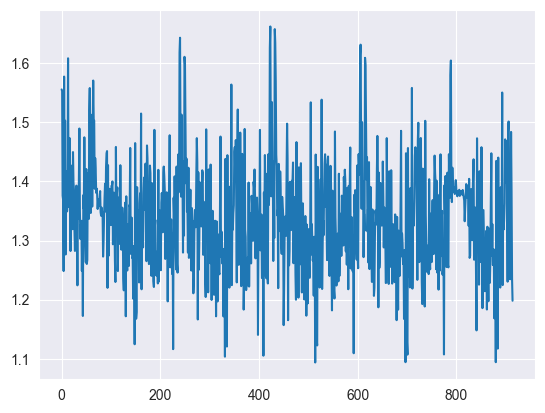

CLG accuracy: 0.6218256691832532
CGA accuracy: 0.5669183253260124
working on new fold
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
[1.4588667154312134, 1.4996442794799805, 1.4028370380401611, 1.413824200630188, 1.3619427680969238, 1.416540265083313, 1.4470168352127075, 1.4014475345611572, 1.438062310218811, 1.2721433639526367, 1.4549105167388916, 1.3620210886001587, 1.4061670303344727, 1.5008713006973267, 1.4213231801986694, 1.37796950340271, 1.4421043395996094, 1.424802303314209, 1.2442998886108398, 1.338287591934204, 1.4135723114013672, 1.3617304563522339, 1.4073158502578735, 1.3203346729278564, 1.4898103475570679, 1.3454830646514893, 1.3960636854171753, 1.287527084350586, 1.2508379220962524, 1.3885822296142578, 1.3975821733474731, 1.355375051498413, 1.232045292854309, 1.4032187461853027, 1.4028195142745972, 1.451601505279541, 1.4095685482025146, 1.279055118560791, 1.3320982456207275, 1.36018967628479, 1.2737892866134644, 1.3245729207992554, 1.2050912380218506, 1.3177835941314697, 1.35583

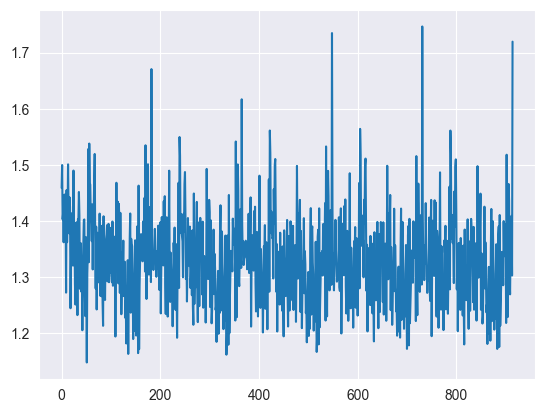

CLG accuracy: 0.5792724776938916
CGA accuracy: 0.5428963623884695
working on new fold
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
[1.4163117408752441, 1.665483832359314, 1.4250693321228027, 1.352973222732544, 1.3228076696395874, 1.4258688688278198, 1.436816930770874, 1.352839708328247, 1.4003328084945679, 1.3564002513885498, 1.4519916772842407, 1.325012445449829, 1.4119681119918823, 1.5108603239059448, 1.3921849727630615, 1.4792284965515137, 1.3353455066680908, 1.336388111114502, 1.491668462753296, 1.3346877098083496, 1.4228664636611938, 1.334214687347412, 1.370872139930725, 1.3590929508209229, 1.4836939573287964, 1.3220956325531006, 1.3221653699874878, 1.226271152496338, 1.320499300956726, 1.345682144165039, 1.3778637647628784, 1.3123670816421509, 1.2864251136779785, 1.3160367012023926, 1.4632097482681274, 1.39316987991333, 1.359833836555481, 1.3496445417404175, 1.3250268697738647, 1.3890432119369507, 1.2958420515060425, 1.3200864791870117, 1.2113479375839233, 1.2889386415481567, 1.267086

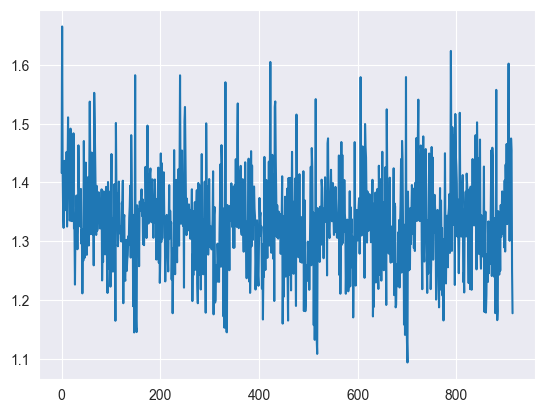

CLG accuracy: 0.5538778311599176
CGA accuracy: 0.5497597803706246
working on new fold
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
[1.4138277769088745, 1.516440987586975, 1.5043076276779175, 1.4888701438903809, 1.3742740154266357, 1.4984334707260132, 1.4343161582946777, 1.3874263763427734, 1.480126142501831, 1.415415644645691, 1.4079629182815552, 1.3696484565734863, 1.4777954816818237, 1.4861655235290527, 1.3726370334625244, 1.4509819746017456, 1.3600441217422485, 1.3673886060714722, 1.2977803945541382, 1.3726119995117188, 1.498349905014038, 1.2441564798355103, 1.3803400993347168, 1.4154247045516968, 1.5219552516937256, 1.4223989248275757, 1.388215184211731, 1.268282413482666, 1.364047646522522, 1.3137973546981812, 1.3601694107055664, 1.4133042097091675, 1.3204530477523804, 1.3359711170196533, 1.3261761665344238, 1.4580405950546265, 1.4178524017333984, 1.2913727760314941, 1.3480217456817627, 1.392478585243225, 1.395891785621643, 1.3567277193069458, 1.3041024208068848, 1.2627431154251099, 1.

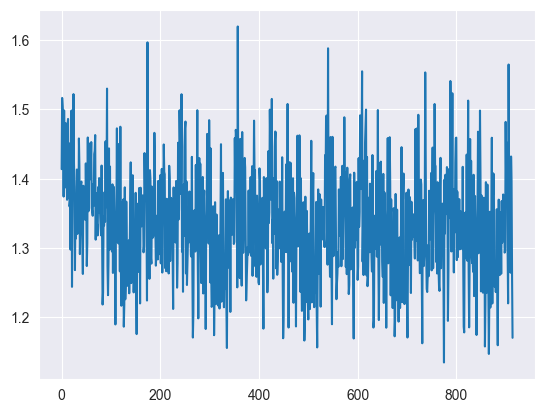

CLG accuracy: 0.5833905284831846
CGA accuracy: 0.5326012354152367
working on new fold
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
[1.4248456954956055, 1.523459792137146, 1.3494740724563599, 1.3803129196166992, 1.355545163154602, 1.5181567668914795, 1.2778903245925903, 1.409659743309021, 1.4143693447113037, 1.31747567653656, 1.3505046367645264, 1.4705220460891724, 1.3454368114471436, 1.4399460554122925, 1.3533231019973755, 1.3837378025054932, 1.352593183517456, 1.358391523361206, 1.5608187913894653, 1.3456311225891113, 1.4768245220184326, 1.3007543087005615, 1.3764402866363525, 1.4361069202423096, 1.4973942041397095, 1.358041763305664, 1.39503014087677, 1.291150450706482, 1.2625455856323242, 1.2786730527877808, 1.3655107021331787, 1.3364907503128052, 1.3280763626098633, 1.3538427352905273, 1.3146378993988037, 1.4112951755523682, 1.3015530109405518, 1.3013651371002197, 1.304532766342163, 1.3232771158218384, 1.3577932119369507, 1.276384711265564, 1.2244977951049805, 1.1848695278167725, 1.3233

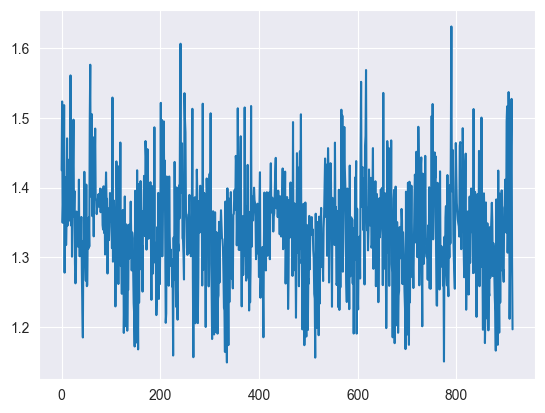

ValueError: Input contains NaN.

In [102]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import binarize


# TODO: 75-80
for train_index,test_index in kfold.split(x,y):
    print("working on new fold")
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    CLGloss = train_CLG(x_train, y_train, x_test, test_index) # CNN LSTM Fourier
    CGAloss = train_CGA(x_train, y_train, x_test, test_index) # CNN GRU Attention
    print(CGAloss)
    plt.plot(CGAloss)
    plt.show()
    
    CLGprediction = np.asarray(record["CLG Predictions"][test_index])
    CGAprediction = np.asarray(record["CGA Predictions"][test_index])
    # print(prediction)
    print("CLG accuracy:", accuracy_score(y_test, binarize(CLGprediction.reshape(-1, 1), threshold=0.5)))
    print("CGA accuracy:", accuracy_score(y_test, binarize(CGAprediction.reshape(-1, 1), threshold=0.5)))


In [ ]:


plt.figure(figsize=(18, 6))
plt.plot(record["CGA Predictions"], label="CGA")
plt.plot(record["CLG Predictions"], label="CLG")
# plt.plot(df["point_victor"], label="truth")
plt.legend()
plt.xlim(left=500, right=700)


In [ ]:
# TODO: 可以调整
weight = 0.3
df['Final Predictions'] = record['CGA Predictions']*weight + record['CLG Predictions']*(1-weight)

In [ ]:
# 遍历每个不同的match_id
for match_id, group_data in grouped_data:
    # 创建子集数据
    subset_df = group_data.copy()
    subset_df['point_no'] = subset_df['point_no'].astype(float)
    
    # 创建折线图
    plt.figure(figsize=(18, 6))
    plt.plot(subset_df['point_no'], subset_df['final_pred'], marker='o', linestyle='-')
    plt.xlabel('point_no')
    plt.ylabel('Predicted Probability')
    plt.title(f'Predicted Probability vs. point_no for match_id {match_id}')
    plt.grid(True)
    
    # 显示或保存图形
    plt.show()  # 或者 plt.savefig('match_id_{}.png'.format(match_id)) 用于保存图形


# subset_df = df.iloc[1483:1502]

# # 创建折线图
# plt.figure(figsize=(12, 6))
# plt.plot(subset_df['point_no'], subset_df['predicted_probability'], marker='o', linestyle='-')
# plt.xlabel('point_no')
# plt.ylabel('Predicted Probability')
# plt.title('Predicted Probability vs. point_no')
# plt.grid(True)
# plt.show()